# Project 01-Benson (Draft 3.0)

## Do-List for Today

* pickle initial DF
* write weight formula(s)
* write formula for apply
* write apply to generate column of weights
* scatterplot for station traffic v. weight
* slide mock-ups

## 0. List of Imports

In [88]:
# from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import googlemaps
import re
import json
import pickle
import copy
import os

from geopy.distance import vincenty
from IPython.display import Image

# sets Google Maps API key to a variable
dl_google_key = os.environ['gmAPI']

%matplotlib inline

## 1. Loading the Dataset

In [3]:
# load it all up with URLs 
datelist = ['170506', '170513', '170520', '170527', '170603']
may_df_raw = pd.DataFrame()
base_url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'

for date in datelist:
    csv_url = f"{base_url}{date}.txt"
    print("Loading", csv_url)
    new_df = pd.read_csv(csv_url)
    may_df_raw = pd.concat([may_df_raw, new_df], ignore_index = True)

Loading http://web.mta.info/developers/data/nyct/turnstile/turnstile_170506.txt
Loading http://web.mta.info/developers/data/nyct/turnstile/turnstile_170513.txt
Loading http://web.mta.info/developers/data/nyct/turnstile/turnstile_170520.txt
Loading http://web.mta.info/developers/data/nyct/turnstile/turnstile_170527.txt
Loading http://web.mta.info/developers/data/nyct/turnstile/turnstile_170603.txt


## 2. Preliminary Cleaning of the Data

In [5]:
# Column 'EXITS' has a ton of whitespaces in the name, so we strip it
for col in may_df_raw.columns:
    may_df_raw.rename(columns = {col: col.strip()}, inplace=True)
may_df_raw.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

### Creating Unique Station Names

In [186]:
may_df_raw["UNIQUE_STATION"] = may_df_raw["STATION"] + ' - ' + may_df_raw["LINENAME"]

# this station appeared with a duplicate name, henceforth united
may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == '4AV-9 ST - DFGMNR', 'UNIQUE_STATION'] = '4 AV-9 ST - DFGMNR'
# Google thinks this one is in Manhattan, so we clarify to Brooklyn
may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'FULTON ST - G', 'UNIQUE_STATION'] = 'FULTON ST (BKLYN) - G'

# these get clarified because the Google Maps API won't recognize them otherwise
# may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'CONEY IS-STILLW - DFNQ', 'UNIQUE_STATION'] = 'CONEY ISLAND-STILLWELL AV - DFNQ'
# may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'HOWARD BCH JFK - A', 'UNIQUE_STATION'] = 'HOWARD BEACH JFK - A'
# may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == '21 ST-QNSBRIDGE - F', 'UNIQUE_STATION'] = '21 ST-QUEENSBRIDGE - F'
# may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'HOYT-SCHER - ACG', 'UNIQUE_STATION'] = 'HOYT-SCHERMERHORN - ACG'
# may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'COURT SQ - EMG', 'UNIQUE_STATION'] = 'COURT SQUARE - EMG'
# may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'GRD CNTRL-42 ST - 4567S', 'UNIQUE_STATION'] = 'GRAND CENTRAL-42 ST - 4567S'
# may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'AQUEDUCT N.COND - A', 'UNIQUE_STATION'] = 'AQUEDUCT N.CONDUIT - A'
# may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'FULTON ST - 2345ACJZ', 'UNIQUE_STATION'] = 'FULTON STREET - 2345ACJZ'

# confirm that duplicate station names are now made unique when merged with line name
# for station in sorted(may_df_raw["UNIQUE_STATION"].unique()):
#     print(station)

### Sort for Sequential Turnstile Data

Because we loaded multiple weeks of data in series, the sequence of data for each station and turstile is broken up. Becuase SCP numbers are not unique within the system — or within a station — we have to sort in the following order:
1. unique station
+ remote unit (UNIT)
+ control area (C/A)
+ turnstile (SCP)
+ date
+ time

In [7]:
may_df_sorted = may_df_raw.sort_values(['UNIQUE_STATION', 'UNIT', 'C/A', 'SCP', 'DATE', 'TIME']).reset_index()
may_df_sorted.head(5)

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,UNIQUE_STATION
0,29387,H007,R248,00-00-00,1 AV,L,BMT,04/29/2017,00:00:00,REGULAR,12278147,13533772,1 AV - L
1,29388,H007,R248,00-00-00,1 AV,L,BMT,04/29/2017,04:00:00,REGULAR,12278188,13534099,1 AV - L
2,29389,H007,R248,00-00-00,1 AV,L,BMT,04/29/2017,08:00:00,REGULAR,12278271,13534359,1 AV - L
3,29390,H007,R248,00-00-00,1 AV,L,BMT,04/29/2017,12:00:00,REGULAR,12278813,13535235,1 AV - L
4,29391,H007,R248,00-00-00,1 AV,L,BMT,04/29/2017,16:00:00,REGULAR,12279597,13536282,1 AV - L


#### What are all the divisions we have presenet?

In [10]:
may_df.DIVISION.unique()

array(['BMT', 'IRT', 'IND', 'PTH', 'RIT', 'SRT'], dtype=object)

* BMT, IRT, and IND are the three companies that were absorbed into the MTA
* PTH is the PATH train into NJ
* SRT is perhaps the Staten Island Railway?

### Filter Unneccsary Columns

We no longer need STATION and LINE, as those have been merged to provide reasonably unique station identification. An exploration of DESC reveals that it has no significant impact on the actual count of entries/exits, so that goes too.

In [9]:
may_df = may_df_sorted.filter(['UNIQUE_STATION', 'UNIT', 'C/A', 'SCP', 'DIVISION', 'DATE', 'TIME',
       'ENTRIES', 'EXITS'])

# look at 50 rows for kicks
# may_df.sample(50, random_state=23)

## 3. Determining Total Entries and Exits per Station

Calculating the difference between one cell in ENTRIES or EXITS and the previous theoretically yields the total number of people through the gate in the time elapsed between readings. With reliable figures, one could simply sum the column to find out how many people walked through the gates over the duration of the entire dataframe.

In [227]:
may_df['ENT_DIFF'] = may_df['ENTRIES'].diff()
may_df['EX_DIFF'] = may_df['EXITS'].diff()
may_df.head(5)

,UNIQUE_STATION,UNIT,C/A,SCP,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ENT_DIFF,EX_DIFF,ENTD_ABS,EXD_ABS
0,1 AV - L,R248,H007,00-00-00,BMT,04/29/2017,00:00:00,REGULAR,12278147,13533772,NaN,NaN,0.0,0.0
1,1 AV - L,R248,H007,00-00-00,BMT,04/29/2017,04:00:00,REGULAR,12278188,13534099,41.0,327.0,41.0,327.0
2,1 AV - L,R248,H007,00-00-00,BMT,04/29/2017,08:00:00,REGULAR,12278271,13534359,83.0,260.0,83.0,260.0
3,1 AV - L,R248,H007,00-00-00,BMT,04/29/2017,12:00:00,REGULAR,12278813,13535235,542.0,876.0,542.0,876.0
4,1 AV - L,R248,H007,00-00-00,BMT,04/29/2017,16:00:00,REGULAR,12279597,13536282,784.0,1047.0,784.0,1047.0


### Negative Numbers and Outliers

When we reach the end of one turnstile's count and continue with another, the differnential does not represent an actual count, and must be reset to 0.

Some turnstiles count backwards, so the differential between current and previous cells in ENTRIES or EXITS will be a negative number in those cases, but the absolute value of this number represents a genuine count.

Occasionally, a turnstile is reset or replaced. In the first case the differential will be a negative number, and in the second case the differential could be negative or positive. In either case, the differential will almost always be several orders of magnitude larger than the largest feasible entry or exit count, and will *not* represent actual people passing through the gate.

Another case in which negative numbers appear is that in which several readings from a different turnstile are mislabeled with the current turnstile's SCP number and mixed into the series. This generates alternating negative and positive differentials.

The following makes some corrections and attemps to figure out which numbers might be set as thresholds for negatives and positives for the purpose of filtering out irrelevant data.

### Correcting for Turnstile Transition

To account for the transition from the readings of one turnstile to another, we set ENT_DIFF and EX_DIFF values to 0 whenever a difference in SCP or C/A numbers is found between current row and previous.

In [228]:
# may_df.loc[may_df['SCP'] != may_df['SCP'].shift(+1), 'ENT_DIFF'] = 0.0
# may_df.loc[may_df['SCP'] != may_df['SCP'].shift(+1), 'EX_DIFF'] = 0.0
# may_df.loc[may_df['SCP'] != may_df['SCP'].shift(+1), ['ENT_DIFF', 'EX_DIFF']] = 0.0

# may_df.loc[may_df['C/A'] != may_df['C/A'].shift(+1), 'ENT_DIFF'] = 0.0
# may_df.loc[may_df['C/A'] != may_df['C/A'].shift(+1), 'EX_DIFF'] = 0.0
# may_df.loc[may_df['C/A'] != may_df['C/A'].shift(+1), ['ENT_DIFF', 'EX_DIFF']] = 0.0

(may_df
 .loc[
     (may_df['SCP'] != may_df['SCP'].shift(+1)) | (may_df['C/A'] != may_df['C/A'].shift(+1)),
     ['ENT_DIFF', 'EX_DIFF']] = 0.0
)

### Finding Thresholds for Filtering

Theoretically, one filter value should be able to be used on the absolute value of the whole series in each ENT_DIFF and EX_DIFF column. However, there are some cases only observed with positive counts that make an argument for setting different threshold values.

#### Negative Differentials

To find a threshold to use for our filter on negative numbers, we look at summary stats and histograms of all negative values in ENT_DIFF and EX_DIFF columns.

In [223]:
entries_neg = may_df[may_df['ENT_DIFF'] < 0]['ENT_DIFF']
exits_neg = may_df[may_df['ENT_DIFF'] < 0]['EX_DIFF']

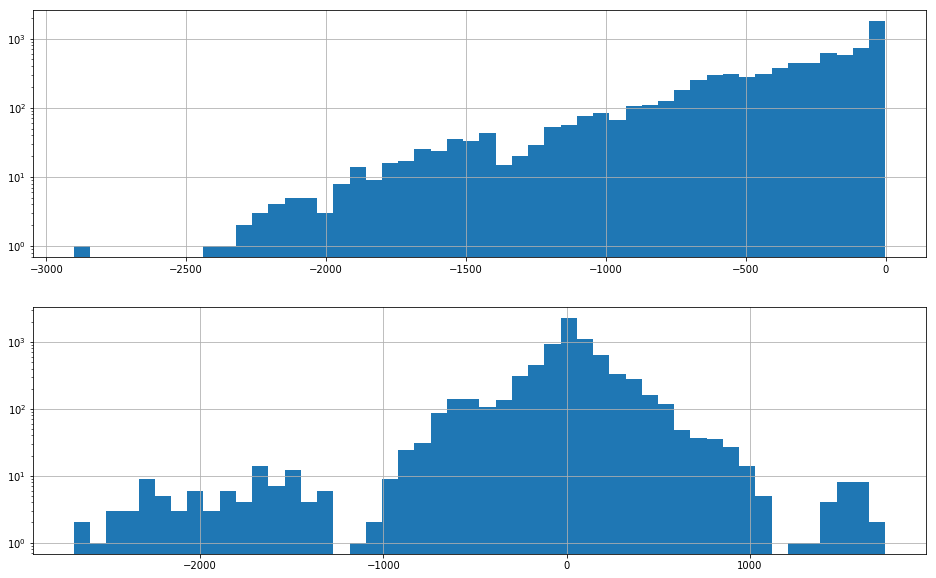

In [230]:
# histogram of negative numbers in entries with y-axis on log scale
# how to display exits too? check the viz tutorial...

fig, ax = plt.subplots(2, 1, figsize=(16,10))

plots_to_make = [entries_neg, exits_neg]

for series, ax_obj in zip(plots_to_make, ax):
    ax_obj.hist(series, bins=50)
    ax_obj.set_yscale('log')
    ax_obj.grid()

In [233]:
entries_neg.describe()

count    7583.000000
mean     -366.066728
std       384.914764
min     -2903.000000
25%      -544.500000
50%      -241.000000
75%       -66.000000
max        -1.000000
Name: ENT_DIFF, dtype: float64

In [234]:
exits_neg.describe()

count    7583.000000
mean       -1.335751
std       341.862930
min     -2691.000000
25%       -81.000000
50%        12.000000
75%       123.000000
max      1740.000000
Name: EX_DIFF, dtype: float64

Nearly all values between -3000 > n > 0 can be attributed to a reverse-counting turnstile, and all values n < -3000 can be attrubuted to a reset or another anomaly.

### Positive Differentials

Again, we look at histograms and summary stats of positive entrance and exit differentials to hone in on a filter threshold.

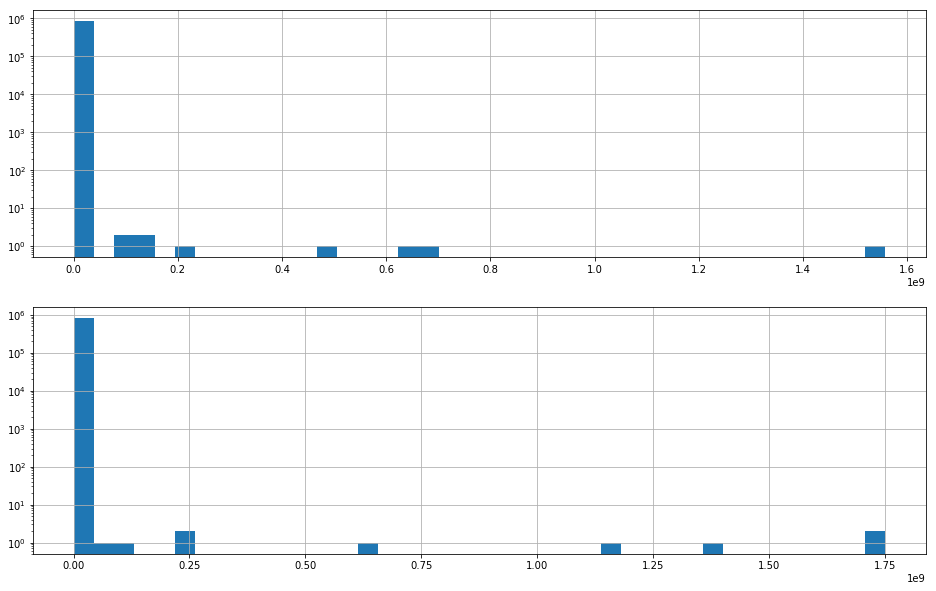

In [232]:
min_val = 0
max_val = 16000

# if we want to look at a range instead of the whole field
ent_pos_slice = may_df[(may_df['ENT_DIFF'] > min_val) & (may_df['ENT_DIFF'] < max_val)]['ENT_DIFF']
ex_pos_slice = may_df[(may_df['EX_DIFF'] > min_val) & (may_df['EX_DIFF'] < max_val)]['EX_DIFF']

ent_pos = may_df[may_df['ENT_DIFF'] > 0]['ENT_DIFF']
ex_pos = may_df[may_df['EX_DIFF'] > 0]['EX_DIFF']


plots_to_make = [ent_pos, ex_pos]

fig, ax = plt.subplots(2, 1, figsize=(16,10))

for series, ax_obj in zip(plots_to_make, ax):
    ax_obj.hist(series, bins=40)
    ax_obj.set_yscale('log')
    ax_obj.grid()

In [28]:
ent_pos.describe()

count    8.216090e+05
mean     5.293635e+03
std      2.108554e+06
min      1.000000e+00
25%      3.200000e+01
50%      1.200000e+02
75%      2.990000e+02
max      1.557696e+09
Name: ENT_DIFF, dtype: float64

In [237]:
ex_pos.describe()

count    8.266290e+05
mean     9.030425e+03
std      3.444267e+06
min      1.000000e+00
25%      2.300000e+01
50%      7.800000e+01
75%      2.040000e+02
max      1.751213e+09
Name: EX_DIFF, dtype: float64

In [238]:
ent_pos.sort_values(ascending=False).head(10)

574146    1.557696e+09
312004    6.831548e+08
652164    6.528036e+08
655513    4.884515e+08
428619    1.979471e+08
227874    1.475619e+08
295648    1.169687e+08
443550    9.825193e+07
12100     8.356122e+07
650838    3.420039e+07
Name: ENT_DIFF, dtype: float64

Unlike the negative numbers, there are a number of counts in the 4000s and even 5000s that appear to be legitimate. As these are quite significant values, we do not want to filter them out of our count. Several values between 6000 and 8000 seem to represent situations in which one turnstile goes offline for several days but keeps on counting, then returns a value representing this whole offline period. As these numbers contribute to an accurate count over the duration of our data, we elect to keep them.

### And We Have Thresholds!

Anything between -3000 and 8000 in the differentials columns will be treated as a real value.

### Filtering Anomalies

In [33]:
# if value in either ENT_DIFF or EX_DIFF falls outside of the range, we set both values to 0

(may_df
 .loc[
    (may_df['ENT_DIFF'] < -3000) | (may_df['EX_DIFF'] < -3000),
    ['ENT_DIFF', 'EX_DIFF']] = 0.0
)
 
(may_df
 .loc[
    (may_df['ENT_DIFF'] > 8000) | (may_df['EX_DIFF'] > 8000),
    ['ENT_DIFF', 'EX_DIFF']] = 0.0
)

We take the absolute value of all diffential and create two new columns for them.

In [ ]:
may_df['ENTRIES_DIFF_ABS'] = may_df['ENT_DIFF'].abs()
may_df['EXITS_DIFF_ABS'] = may_df['EX_DIFF'].abs()

## 4. Calculating the Busiest Stations

...is as easy as grouping by station and showing the sum of entries and exits.

In [217]:
may_df.groupby('UNIQUE_STATION')['ENTRIES_DIFF_ABS', 'EXITS_DIFF_ABS'].sum().head(20)

,ENTD_ABS,EXD_ABS
UNIQUE_STATION,,
1 AV - L,640926.0,667674.0
103 ST - 1,393661.0,187491.0
103 ST - 6,425559.0,351729.0
103 ST - BC,149106.0,106674.0
103 ST-CORONA - 7,646780.0,468924.0
104 ST - A,53015.0,18517.0
104 ST - JZ,45125.0,6815.0
110 ST - 6,375173.0,292366.0
111 ST - 7,373148.0,250502.0


## 5. Location, Location, Location: Enter the Goog

Because we intend to compare station locations to locations of tech companies and universities, we need to grab the latitude and longitude of our stations, companies, and universities to compute that distance. We'll use the Google Maps API to query lat/lng for each one.

In [38]:
def find_location(search_array, search_type, gkey, lcn_dict=None):
    """
    This test function will take in an array of searchable venues, look them up on the Google API, and return their
    location as latitude and longitude.
    
    Type key:
    0. Subway Station
    1. Company
    2. College
    
    ---
    
    IN: ndarray, list, etc. of locations; type (int); Google API key (str)
        * specify dictionary for input if you'd like to add to it
    OUT: dictionary of venues as keys and latitude/longitude as items; venues for which no data was found
    """
    
    gmaps = googlemaps.Client(key=gkey)
    no_value = []
    search_types = ['subway station', 'company headquarters', 'college']
    if lcn_dict == None:
        lcn_dict = {}

    for venue in search_array:
        print(f"Searching for: {venue}                              \r", end='')
        search_me = venue + search_types[search_type] + ' NEW YORK'
        result = gmaps.geocode(search_me)
        if result:
            latitude = result[0]['geometry']['location']['lat']
            longitude = result[0]['geometry']['location']['lng']
        else:
            latitude = np.nan
            longitude = np.nan
            print(f"*** {venue}: No value found!")
            no_value.append(venue)
        lcn_dict[venue] = (latitude, longitude)
        
    print("Complete!                                                   ")
        
    return lcn_dict, no_value

In [183]:
# uncomment code to run these instead of loading from JSON file

station_names = may_df['UNIQUE_STATION'].unique() # numpy array of unique names

station_lcns, stations_nolcndata = find_location(station_names, 0, dl_google_key)

*** AQUEDUCT N.COND - A: No value found!                                   
*** FULTON ST - 2345ACJZ: No value found!                                    
*** NEWARK HW BMEBE - 1: No value found!                                
Complete!                                                                 


In [190]:
for station in stations_nolcndata:
   print(station) 

AQUEDUCT N.COND - A
FULTON ST - 2345ACJZ
NEWARK HW BMEBE - 1


In [198]:
# cycles through stations with no location data and offers opportunity to rename
# both in list and df

for index, station in enumerate(stations_nolcndata[:]):
    print(f"Enter new name for {station} (or hit enter to leave as-is)")
    newname = input("> ").strip()
    if newname != '':
        may_df.loc[may_df['UNIQUE_STATION'] == station, 'UNIQUE_STATION'] = newname
        stations_nolcndata[index] = newname
        del station_lcns[station]

for station in stations_nolcndata:
    print(station)

In [197]:
# try one more time with stations that didn't return lat/lng info
station_lcns_updated, stations_nolcndata = find_location(stations_nolcndata, 0, dl_google_key, lcn_dict=station_lcns)

Complete!                                                            


476

In [40]:

# 50 notable tech companies in NYC
companies = ['Amazon','AOL','Apple','AppNexus','Bloomberg','Blue Apron 40 w 23rd St','BuzzFeed','ETrade','Etsy','Facebook',
                 'Fresh Direct','Google','Information Builders','LinkedIn','MediaRadar','Microsoft','Oscar',
                 'Salesforce','Shutterstock','Spotify','Tumblr','Twitter','VICE Media','WeWork','Yelp','Yext',
                 'Zocdoc','Betterment','Bonobos','Compass','Grubhub','Fareportal','FanDuel','MediaMath',
                 'Integral Ad Science','MondoDB','Sprinklr','Uber','Vimeo','Intersection','Snapchat','Flatiron Health',
                 'Gilt','LearnVest','OnDeck','Squarespace','Thrillist','Warby Parker','TMP Worldwide','Refinery29']

# company_lcns, companies_nolcndata = find_location(companies, 1, dl_google_key)

In [41]:
# 10 notable universities in NYC
colleges = ['City University of New York Harlem','Yeshiva University', 'Columbia University',
            'New York Institute of Technology','New York University','Pace University', 'Fordham University',
            'The New School','Hunter College','Baruch College'] 

# company_and_college_lcns, colleges_nolcndata = find_location(colleges, 2, dl_google_key, lcn_dict=company_lcns)

In [42]:
# throw these into JSON files for later

# with open('station_lcns.txt', 'w') as fs:
#     json.dump(station_lcns, fs)

# with open('candc_lcns.txt', 'w') as fc:
#     json.dump(company_and_college_lcns, fc)

In [ ]:
# and then read them
with open('station_lcns.txt', 'r') as fs:
    station_lcns_current_dict = json.load(fs)
    
with open('candc_lcns.txt', 'r') as fc:
    company_and_college_lcns_current_dict = json.load(fc)

In [43]:
print(len(station_lcns_current_dict))
print(len(company_and_college_lcns_current_dict))

475
60


**FYI, latitude and longitude of NYC:** 
* Latitude = 40.7141667 
* Longitude = -74.0063889

**NEXT UP, MERGE STATION LCNS WITH BUSIEST STATIONS**

I'm not sure why I didn't make these damn things into DFs or Series in the function, but now we try to take dictionaries of lat/lng and merge with the traffic info df using the station names as indices.

In [44]:
station_locations = pd.DataFrame.from_dict(station_lcns_current_dict, orient='index')
company_college_locations = pd.DataFrame.from_dict(company_and_college_lcns_current_dict, orient='index')
station_locations.columns = ['Latitude', 'Longitude']
company_college_locations.columns = ['Latitude', 'Longitude']

In [ ]:
station_locations = station_locations.reindex(station_locations.index.rename('UNIQUE_STATION'))
station_locations.head(10)

In [87]:
company_college_locations.head(10)

,Latitude,Longitude,Product,Sum_again
Amazon,40.749153,-73.985164,-33.236011,-33.236011
AOL,40.730601,-73.991522,-33.260921,-33.260921
Apple,40.881939,-73.988621,-33.106682,-33.106682
AppNexus,40.741897,-73.990914,-33.249017,-33.249017
Bloomberg,40.761749,-73.968004,-33.206255,-33.206255
Blue Apron 40 w 23rd St,40.742038,-73.991444,-33.249406,-33.249406
BuzzFeed,40.741526,-73.999885,-33.258359,-33.258359
ETrade,40.763017,-73.978952,-33.215935,-33.215935
Etsy,40.700582,-73.988146,-33.287563,-33.287563
Facebook,40.730596,-73.991525,-33.260929,-33.260929


In [47]:
may_station_traffic_with_location = may_station_traffic.join(station_locations)
may_station_traffic_with_location.head(10)

,ENTD_ABS,EXD_ABS,TOTAL_TRAFFIC,Latitude,Longitude
UNIQUE_STATION,,,,,
1 AV - L,640926.0,667674.0,1308600.0,40.762988,-73.967866
103 ST - 1,393661.0,187491.0,581152.0,40.790191,-73.947679
103 ST - 6,425559.0,351729.0,777288.0,40.790191,-73.947679
103 ST - BC,149106.0,106674.0,255780.0,40.749799,-73.862687
103 ST-CORONA - 7,646780.0,468924.0,1115704.0,40.749799,-73.862687
104 ST - A,53015.0,18517.0,71532.0,40.695178,-73.844330
104 ST - JZ,45125.0,6815.0,51940.0,40.695178,-73.844330
110 ST - 6,375173.0,292366.0,667539.0,40.804255,-73.966393
111 ST - 7,373148.0,250502.0,623650.0,40.751730,-73.855334


### Not sure yet where to put the following cell that creates a filtered DF for computations...

This will change if we append location info to may_df beforehand.

In [ ]:
may_station_traffic = may_df.groupby('UNIQUE_STATION')['ENTRIES_DIFF_ABS', 'EXITS_DIFF_ABS'].sum()
may_station_traffic['TOTAL_TRAFFIC'] = may_station_traffic['ENTD_ABS'] + may_station_traffic['EXD_ABS']
may_station_traffic.head(10)
# may_station_traffic_total = may_station_traffic['ENTD_ABS'] + may_station_traffic['EXD_ABS']
# may_station_traffic_total.sort_values(ascending=False).head(50)

In [95]:
practice_df = copy.deepcopy(may_station_traffic_with_location)

In [49]:
Penn123_lat = practice_df.loc['34 ST-PENN STA - 123', 'Latitude']
Penn123_lng = practice_df.loc['34 ST-PENN STA - 123', 'Longitude']

In [58]:
def calculate_distance(lat1, lng1, lat2, lng2):
    """Takes the latitude and longitude of two points, calculates distance, and returns 
    it in miles.
    ---
    IN: Two pairs of lat/lng (int or float)
    OUT: Distance between in miles (float)
    """
    
    ll_1 = (lat1, lng1)
    ll_2 = (lat2, lng2)
    
    return vincenty(ll_1,ll_2).miles

In [110]:
# a couple different ways of weighting a station based on proximity to companies/colleges

def find_weight1(dist):
    """Returns a number from 0-1 based on distance between station and company/college,
    favoring closer distances and discounting anything farther than 1 mile away.
    ---
    IN: Distance in miles (int or float)
    OUT: Weight between 0 and 1 (int or float)
    """
    if 0 < dist <= 0.25:
        weight = 1
    elif 0.25 < dist <= 0.5:
        weight = 0.75
    elif 0.5 < dist <= 0.75:
        weight = 0.5
    elif 0.75 < dist <= 1:
        weight = 0.25
    else:
        weight = 0
    
    return weight

def find_weight2(dist):
    """Returns a number from 0-1 based on a curve we thought might represent the 
    likelihood that someone at a particular company/college would use the 
    corresponding station. It is completely subjective and has no correlation with
    any collected or observed data whatsoever, so justifying its use would be 
    difficult. Still, we were curious to see how it might work, so we coded it up
    as an option.
    ---
    IN: Distance in miles (int or float)
    OUT: Weight between 0 and 1 (float)

    """
    
    return 1 - (1 - 1/50**dist)**4

In [147]:
def station_weight(s_lat, s_lng):
    """To be applied to the stations DF to find cumulative weighting for each
    station based on proximity to companies/colleges of interest.
    ---
    IN: DF row (series obj)
    OUT: Cumulative weight (float)"""
    
    if s_lat is np.nan:
        return np.nan
    
    weight_list = []
    
    for row in company_college_locations.iterrows():
        c_lat = row[1][0]
        c_lng = row[1][1]
        dist = calculate_distance(s_lat, s_lng, c_lat, c_lng)

        # change formula name to use 
        weight = find_weight1(dist)
        weight_list.append(weight)

    cumulative_weight = np.sum(weight_list)
    
    return cumulative_weight

In [148]:
station_weight(Penn123_lat, Penn123_lng)

16.25

In [181]:
# practice_df['Weight'] = practice_df.apply(lambda row: station_weight(row['Latitude'], row['Longitude']), axis=1)
practice_df['Latitude'].dtype

dtype('float64')

In [154]:
ccl_test = copy.deepcopy(company_college_locations)

In [155]:
def sum_ll(a, b):
    return a + b

def div_by_two(a, b):
    return pd.Series((a/2, b/2))
    
ccl_test['New'] = ccl_test.apply(lambda row: sum_ll(row['Latitude'], row['Longitude']), axis=1)
# pd.concat([ccl_test, ccl_test.apply(lambda row: div_by_two(row['Latitude'], row['Longitude']), axis=1)])
ccl_test.head(10)

,Latitude,Longitude,New
Amazon,40.749153,-73.985164,-33.236011
AOL,40.730601,-73.991522,-33.260921
Apple,40.881939,-73.988621,-33.106682
AppNexus,40.741897,-73.990914,-33.249017
Bloomberg,40.761749,-73.968004,-33.206255
Blue Apron 40 w 23rd St,40.742038,-73.991444,-33.249406
BuzzFeed,40.741526,-73.999885,-33.258359
ETrade,40.763017,-73.978952,-33.215935
Etsy,40.700582,-73.988146,-33.287563
Facebook,40.730596,-73.991525,-33.260929
